In [1]:
import os
if os.getcwd().split("/")[-1] != "neurolib":
    os.chdir('..')

os.chdir('..')
datadir = os.path.join(os.getcwd(), "neurolib", "notebooks_frontiers24")

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from numba.typed import Dict
from numba.core import types

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel

from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

def plot_control(control, state, dur, dt):
    fig, ax = plt.subplots(2,1, figsize=(16,8), sharex=True)
    time_array = np.arange(0, dur+dt, dt)

    for n in range(N):
        ax[0].plot(time_array, state[n,0,:])
        ax[1].plot(time_array, control[n,0,:])

    ax[0].set_xlim(0, dur)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")
    fig.align_ylabels([ax[:]])

    plt.show()
    return


def getperiod(data, dt):
    for i_d,d in enumerate(data):
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)] / (len(ps)/2)
        ps_plot[0] = 0.
        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))

    return (1./fr[maxfreqind])[0]

def set_weight_sync(model, method, weight):
    model.weights["w_p"] = 0.
    model.weights["w_2"] = 1.
    
    if method == "F":
        model.weights["w_f_sync"] = weight
    elif method == "CC":
        model.weights["w_cc"] = weight
    elif method == "VAR":
        model.weights["w_var"] = weight
    return

def optimize_model(model, exprange, it):
    for k in exprange:
        model.zero_step_encountered = False
        model.step = 10**(k)
        model.optimize(it)
    model.zero_step_encountered = False

    return

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
N = 6

cmat = np.array([[0., 1., 0., 0., 0., 1.],
 [1., 0., 1., 0., 1., 0.],
 [0., 0., 0., 0., 0., 1.],
 [0., 0., 1., 0., 0., 1.],
 [1., 1., 0., 1., 0., 1.],
 [0., 1., 1., 0., 0., 0.]])
dmat = np.array( [[ 0., 12.,  0.,  0.,  0.,  8.],
 [ 8.,  0., 13.,  0.,  1.,  0.],
 [ 0.,  0.,  0.,  0.,  0.,  9.],
 [ 0.,  0.,  4.,  0.,  0., 11.],
 [ 5., 17.,  0., 14.,  0., 18.],
 [ 0.,  0.,  3.,  0.,  0.,  0.]])

coupling = 0.8

In [4]:
coords_sync = [1.6, 0.4]

data_sync = dict()
data_sync["control"] = [None, None, None]
data_sync["state"] = [None, None, None]
data_sync["init"] = [None, None]
data_sync["weights"] = np.ones((3))
data_sync["control_cost"] = np.zeros((3))
data_sync["sync_cost"] = np.zeros((3))

In [7]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling

dur = 4000.
measure_dur = 30.
i00, i01 = 0, 100
i10, i11 = 20000, 20100

model.params['duration'] = dur 
test_input = ZeroInput().generate_input(duration=model.params['duration']+model.params.dt, dt=model.params.dt)
test_input[:,i00:i01] = 6.
test_input[:,i10:i11] = -6.
model.params.exc_ext_baseline = coords_sync[0]
model.params.inh_ext_baseline = coords_sync[1]
model.params.exc_ext = test_input
model.run()

maxdelay = model.getMaxDelay()

einit = np.zeros((N, maxdelay+1))
iinit = np.zeros((N, maxdelay+1))

for n in range(N):
    einit[n,:] = model.exc[n, -maxdelay-1:]
    iinit[n,:] = model.inh[n, -maxdelay-1:]

data_sync["init"][0] = einit
data_sync["init"][1] = iinit

period_async = getperiod( [model.exc[0,-10000:], model.exc[1,-10000:], model.exc[2,-10000:],
                              model.exc[3,-10000:], model.exc[4,-10000:], model.exc[5,-10000:]], model.params.dt)

In [8]:
coords_deync = [1., 0.4]

data_desync = dict()

data_desync["control"] = [None, None, None]
data_desync["state"] = [None, None, None]
data_desync["init"] = [None, None]
data_desync["weights"] = np.ones((3))
data_desync["control_cost"] = np.zeros((3))
data_desync["sync_cost"] = np.zeros((3))

In [9]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling

model.params['duration'] = dur 
model.params.exc_ext_baseline = coords_deync[0]
model.params.inh_ext_baseline = coords_deync[1]
model.params.exc_ext = test_input
model.run()

maxdelay = model.getMaxDelay()

einit = np.zeros((N, maxdelay+1))
iinit = np.zeros((N, maxdelay+1))

for n in range(N):
    einit[n,:] = model.exc[n, -maxdelay-1:]
    iinit[n,:] = model.inh[n, -maxdelay-1:]

data_sync["init"][0] = einit
data_sync["init"][1] = iinit

period_async = getperiod( [model.exc[0,-10000:], model.exc[1,-10000:], model.exc[2,-10000:],
                              model.exc[3,-10000:], model.exc[4,-10000:], model.exc[5,-10000:]], model.params.dt)

In [11]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1

costmat = np.zeros((N,2))
costmat[:,0] = 1

duration = 800
control_interval = [1000, -2000]
cost_interval = [1000, -2000]

max_cntrl = 5
pr = np.arange(0,501,10)

In [12]:
data_sync["weights"][0] = 18600
data_sync["weights"][1] = 4711
data_sync["weights"][2] = 45000

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.019265237636619272
Final cost : -0.019265237636619272
Compute control for a deterministic system
Cost in iteration 0: -0.019265237636619272
Cost in iteration 10: -4.844780552907161
Cost in iteration 20: -5.973669413296546
Final cost : -5.973669413296546
Compute control for a deterministic system
Cost in iteration 0: -5.973669413296546
Cost in iteration 10: -6.548897335237643
Cost in iteration 20: -8.780013315805615
Final cost : -8.780013315805615
Compute control for a deterministic system
Cost in iteration 0: -8.780013315805615
Cost in iteration 10: -9.004620810788673
Cost in iteration 20: -9.181616617459252
Final cost : -9.181616617459252
Compute control for a deterministic system
Cost in iteration 0: -9.181616617459252
Cost in iteration 10: -9.210046137877029
Cost in iteration 20: -9.234938067644045
Final cost : -9.234938067644045
Compute control for a deterministic syste

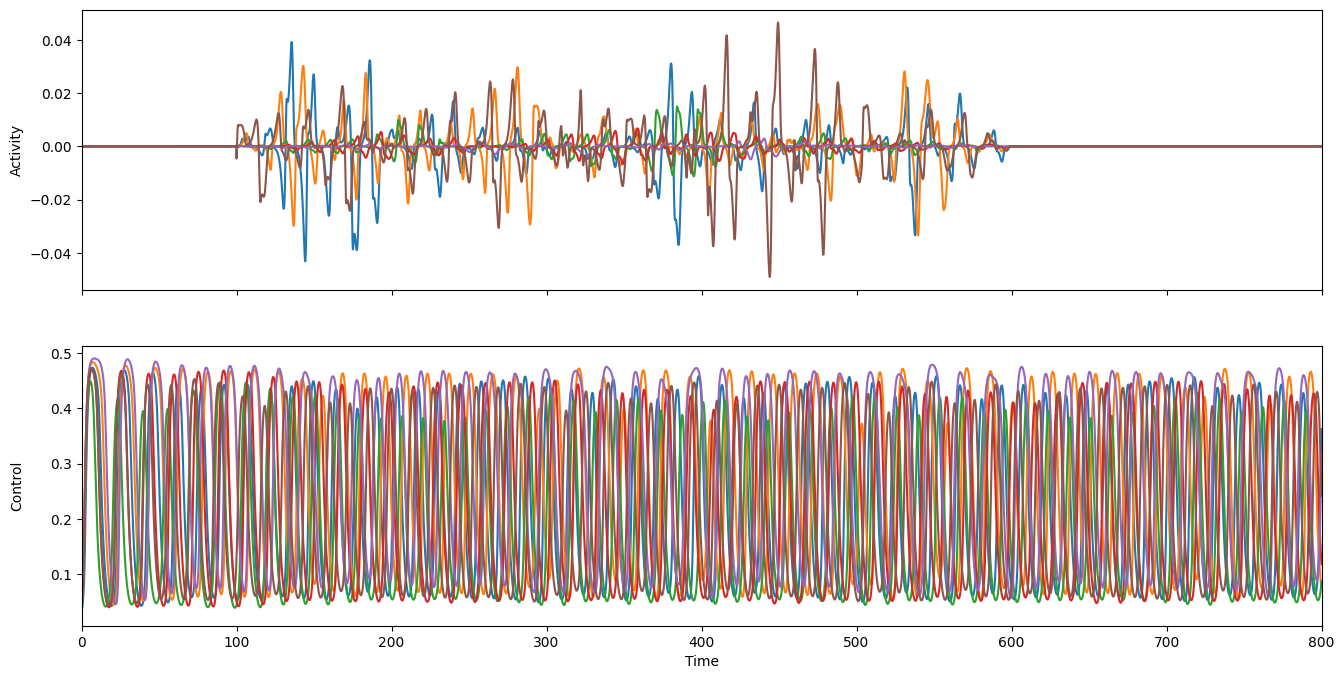

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 219.87640015718682
Final cost : 219.87640015718682
Compute control for a deterministic system
Cost in iteration 0: 219.87640015718682
Cost in iteration 10: -699.1619965535527
Cost in iteration 20: -717.2625729373146
Final cost : -717.2625729373146
Compute control for a deterministic system
Cost in iteration 0: -717.2625729373146
Converged in iteration 1 with cost -717.2625729373146
Final cost : -717.2625729373146
Compute control for a deterministic system
Cost in iteration 0: -717.2625729373146
Converged in iteration 2 with cost -717.2625729373146
Final cost : -717.2625729373146
Compute control for a deterministic system
Cost in iteration 0: -717.2625729373146
Converged in iteration 1 with cost -717.2625729373146
Final cost : -717.2625729373146
Compute control for a deterministic system
Cost in iteration 0: -717.2625729373146
Converged in iteration 1 with cost -717.26257293731

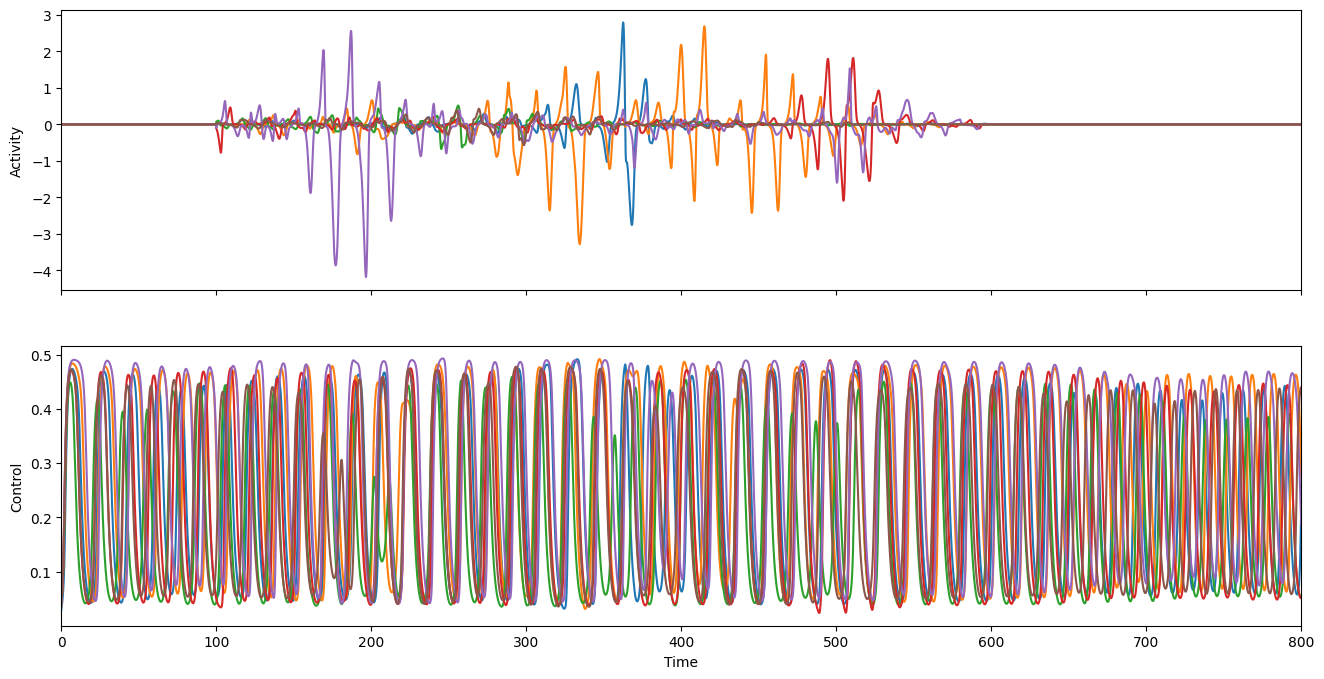

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 895.6799117227789
Final cost : 895.6799117227789
Compute control for a deterministic system
Cost in iteration 0: 895.6799117227789
Cost in iteration 10: 870.1317314275534
Converged in iteration 19 with cost 863.169184520445
Final cost : 863.169184520445
Compute control for a deterministic system
Cost in iteration 0: 863.169184520445
Cost in iteration 10: 830.1874098660141
Converged in iteration 17 with cost 817.7065091538998
Final cost : 817.7065091538998
Compute control for a deterministic system
Cost in iteration 0: 817.7065091538998
Converged in iteration 1 with cost 817.7065091538998
Final cost : 817.7065091538998
Compute control for a deterministic system
Cost in iteration 0: 817.7065091538998
Converged in iteration 2 with cost 817.7065091538998
Final cost : 817.7065091538998
Compute control for a deterministic system
Cost in iteration 0: 817.7065091538998
Converged in it

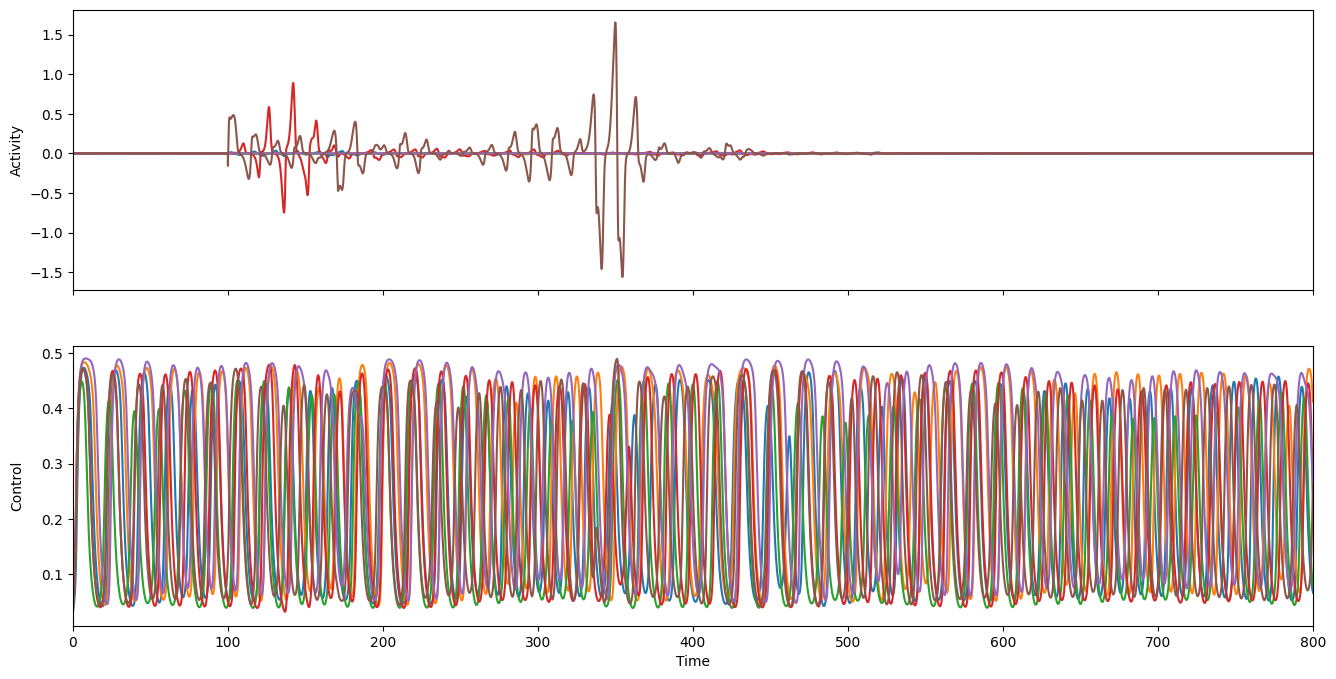

In [19]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling

model.params['duration'] = duration
model.params.exc_ext_baseline = coords_sync[0]
model.params.inh_ext_baseline = coords_sync[1]

model.params["exc_init"] = data_sync["init"][0]
model.params["inh_init"] = data_sync["init"][1]
model.run()

for mi, method in enumerate(["F", "CC", "VAR"]):

    model_controlled = oc_wc.OcWc(model, period_async, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                cost_matrix=costmat, control_matrix=controlmat)

    set_weight_sync(model_controlled, method, data_sync["weights"][mi])
    model_controlled.maximum_control_strength = max_cntrl

    model_controlled.optimize(0)
    model_controlled.channelwise_optimization = True

    # find initial control signal
    optimize_model(model_controlled, np.arange(-4., 7., 2.), 20)

    model_controlled.grad_method = 1
    optimize_model(model_controlled, np.arange(-4., 7., 2.), 10)

    data_sync["control"][mi] = model_controlled.control.copy()
    data_sync["state"][mi] = model_controlled.get_xs()

    coc = cost_functions.control_strength_cost(data_sync["control"][mi], weights, model.params.dt)
    data_sync["control_cost"][mi] = coc
    data_sync["sync_cost"][mi] = (model_controlled.compute_total_cost() - coc)/data_sync["weights"][mi]

    plot_control(data_sync["control"][mi], data_sync["state"][mi], duration, model.params.dt)

In [ ]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling

model.params['duration'] = duration
model.params.exc_ext_baseline = coords_sync[0]
model.params.inh_ext_baseline = coords_sync[1]

model.params["exc_init"] = data_sync["init"][0]
model.params["inh_init"] = data_sync["init"][1]

model.run()

for mi, method in enumerate(["F", "CC", "VAR"]):

    model_controlled = oc_wc.OcWc(model, period_async, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                cost_matrix=costmat, control_matrix=controlmat)
    
    set_weight_sync(model_controlled, method, data_sync["weights"][mi])
    model_controlled.maximum_control_strength = max_cntrl

    model_controlled.control = data_sync["control"][mi].copy()
    model_controlled.update_input()

    model_controlled.optimize(0)
    model_controlled.channelwise_optimization = True

    for j in range(100):
        model_controlled.grad_method = 0
        optimize_model(model_controlled, np.arange(-4., 7., 2.), 20)

        model_controlled.grad_method = 1
        optimize_model(model_controlled, np.arange(-4., 7., 2.), 10)

    data_sync["control"][mi] = model_controlled.control.copy()
    data_sync["state"][mi] = model_controlled.get_xs()

    coc = cost_functions.control_strength_cost(data_sync["control"][mi], weights, model.params.dt)
    data_sync["control_cost"][mi] = coc
    data_sync["sync_cost"][mi] = (model_controlled.compute_total_cost() - coc)/data_sync["weights"][mi]

    plot_control(data_sync["control"][mi], data_sync["state"][mi], duration, model.params.dt)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -59.543297942567875
Final cost : -59.543297942567875
Compute control for a deterministic system
Cost in iteration 0: -59.543297942567875
Converged in iteration 1 with cost -59.543297942567875
Final cost : -59.543297942567875
Compute control for a deterministic system
Cost in iteration 0: -59.543297942567875
Converged in iteration 1 with cost -59.543297942567875
Final cost : -59.543297942567875
Compute control for a deterministic system
Cost in iteration 0: -59.543297942567875
Converged in iteration 1 with cost -59.543297942567875
Final cost : -59.543297942567875
Compute control for a deterministic system
Cost in iteration 0: -59.543297942567875
Converged in iteration 1 with cost -59.543297942567875
Final cost : -59.543297942567875
Compute control for a deterministic system
Cost in iteration 0: -59.543297942567875
Converged in iteration 1 with cost -59.543297942567875
Final cos